# Encoding position with multiple harmonics simultaneously

* The circulant matrix Fourier equations give us $2^N$ possible circuits that could do path integration
* Does it make sense to encode a position with a combination of harmonics at the same time?
  * By default, each harmonic's waveform will move with a different speed around the ring
  * This will cause combined waveforms to change shape -- which we don't want
  * We can instead scale up the angle encoded by higher harmonics so their waveforms move at the same speed as the fundamental frequency waveform
  * But, this will reduce the range of angles these harmonics can encode to $[0,\frac{2\pi}{f}]$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
plt.style.use('seaborn-v0_8-notebook')
np.random.seed(7) # seed so plots are repeatable
plt.rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
plt.rc('text', usetex=True)
%matplotlib inline
# need the %matplotlib inline for the following to work
plt.rc('figure', figsize = [8,6]) # paper figures should be width 8 (full linewidth) to have nicely readable text

In [2]:
N = 8
neuron_indices = np.atleast_2d(np.arange(N)).T
neuron_indices_high_res = np.atleast_2d(np.arange(0,N,0.01)).T

get_activity = lambda theta, fs, indices, scaled: np.sum([np.cos(-theta*(f if scaled else 1) + 2*np.pi*f*indices/N) for f in fs], axis=0)
activity = lambda theta, fs, scaled: get_activity(theta, fs, neuron_indices, scaled)
activity_high_res = lambda theta, fs, scaled: get_activity(theta, fs, neuron_indices_high_res, scaled)

# plot_activity = lambda theta, f: plt.plot(neuron_indices_high_res, activity(theta, f))
def plot_activity(theta, fs, scaled=True):
	plt.plot(neuron_indices_high_res, activity_high_res(theta, fs, scaled), 'k--', lw=1, label='Abstract waveform')
	plt.plot(neuron_indices, activity(theta, fs, scaled), 'o', label='Neural activity')

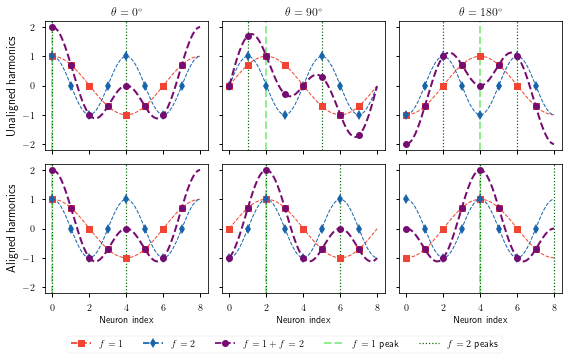

In [33]:
fig, axs = plt.subplots(2,3, figsize=(8,5), sharex=True, sharey=True)

def plot_activity(theta, fs, scaled, label, markerstyle, lw=1, **kwargs):
	plt.plot(neuron_indices_high_res, activity_high_res(theta, fs, scaled), '--', lw=lw, **kwargs)
	plt.plot(neuron_indices, activity(theta, fs, scaled), markerstyle, **kwargs)
	plt.plot(np.nan, np.nan, markerstyle+'--', label=label, **kwargs) #plot a dummy for the label

f1_peak_options = {"ls": '--', "color": "lightgreen", "alpha": 1.0, "linewidth": 2}
f2_peak_options = {"ls": 'dotted', "color": "darkgreen", "alpha": 1.0, "linewidth": 1.2}

f1_line_colour = plt.cm.Reds(0.6)#'#c48c98' #plt.cm.Blues(0.3)
f2_line_colour = plt.cm.Blues(0.8)#'#64bc9a' #plt.cm.Blues(0.5)
f12_line_colour = plt.cm.BuPu(0.9)
for n, angle in enumerate([0,np.pi/2,np.pi]):
	plt.sca(axs[0][n])
	plt.axvline(N/2/np.pi*angle, **f1_peak_options, label='$f=1$ peak')
	plt.axvline(N/2/np.pi*angle/2, **f2_peak_options, label='$f=2$ peaks')
	plt.axvline(N/2/np.pi*(angle+2*np.pi)/2, **f2_peak_options)
	plot_activity(angle, [1], False, c=f1_line_colour, label='$f=1$', markerstyle='s')
	plot_activity(angle, [2], False, c=f2_line_colour, label='$f=2$', markerstyle='d')
	plot_activity(angle, [1,2], False, c=f12_line_colour, label='$f=1+f=2$', markerstyle='o', lw=2)
	plt.title(f'$\\theta={np.degrees(angle):.0f}^\\circ$')
	plt.sca(axs[1][n])
	plt.axvline(N/2/np.pi*angle, **f1_peak_options, label='$f=1$ peak')
	plt.axvline(N/2/np.pi*angle, **f2_peak_options, label='$f=2$ peaks')
	plt.axvline(N/2/np.pi*(angle+np.pi), **f2_peak_options)
	plot_activity(angle, [1], True, c=f1_line_colour, label='$f=1$', markerstyle='s')
	plot_activity(angle, [2], True, c=f2_line_colour, label='$f=2$', markerstyle='d')
	plot_activity(angle, [1,2], True, c=f12_line_colour, label='$f=1+f=2$', markerstyle='o', lw=2)
	plt.xlabel('Neuron index')

# make a legend for the figure just using the legend entries from the first axis
handles, labels = axs[0][0].get_legend_handles_labels()
legend = fig.legend(handles[2:]+handles[:2], labels[2:]+labels[:2], loc='upper center', bbox_to_anchor=(0.5, 0.07), ncol=5)

# make this the same size as a normal title
axs[0][0].set_ylabel('Unaligned harmonics', fontsize=12)
axs[1][0].set_ylabel('Aligned harmonics', fontsize=12)
# plt.suptitle('Harmonics must be aligned to maintain a consistent activity shape as the insect rotates', fontsize=14)

# layout trick to get the legend to fit
bbox = legend.get_window_extent(fig.canvas.get_renderer()).transformed(fig.transFigure.inverted())
plt.tight_layout(rect=(0, bbox.y1, 1, 1))

plt.savefig('plots/combined-harmonics-movement.pdf')
plt.show()

In [6]:
neuron_index_to_xy = lambda index: (np.cos(2*np.pi*index/N), np.sin(2*np.pi*index/N))
cos_sin = lambda x: (np.cos(x), np.sin(x))

encoder = lambda f: lambda r, theta: r*activity(theta, [f], True)
get_pinvT = lambda f: np.linalg.pinv(np.hstack(neuron_index_to_xy(f*neuron_indices)))
xy_decoder = lambda f: (lambda pinvT: lambda a: (pinvT @ a)) (get_pinvT(f))
decoder = lambda f: (lambda xy_decode: lambda a: 1/f*np.arctan2(*xy_decode(a)[::-1,:])) (xy_decoder(f))

all_angles_decoder = lambda f: (lambda xy_decode: lambda a: 2*np.pi/f*np.atleast_2d(np.arange(f)).T + 1/f*np.arctan2(*(xy_decode(a)[::-1,:]))) (xy_decoder(f))
distance_decoder = lambda f: (lambda xy_decode: lambda a: np.sqrt(np.sum(xy_decode(a)**2, axis=0))) (xy_decoder(f))
all_xy_decoder = lambda f: (lambda all_angles_decode, distance_decode: lambda a: distance_decode(a) * cos_sin(all_angles_decode(a))) (all_angles_decoder(f), distance_decoder(f))

# test that we can decode some test angles
# print(all_angles_decoder(1)(encoder(1)(1, np.array([0, 0.3, 0.5, 1]))))
# distance_decoder(1)(encoder(1)(1, np.array([0, 0.3, 0.5, 1])))

all_xy_decoder(2)(encoder(2)(1, np.array([0, 3.14])))

array([[[ 1.00000000e+00,  9.99998732e-01],
        [-1.00000000e+00, -9.99998732e-01]],

       [[ 0.00000000e+00, -1.59265292e-03],
        [ 1.22464680e-16,  1.59265292e-03]]])

In [216]:
gaussian2d = lambda x, y, sigma, mu_x, mu_y: 1/(2*np.pi*sigma**2) * np.exp(-((x-mu_x)**2 + (y - mu_y)**2) / sigma**2)

encoded xy = [1.0,0.0]
decoded xy = [-0.6750000000000065,-0.050000000000008704]


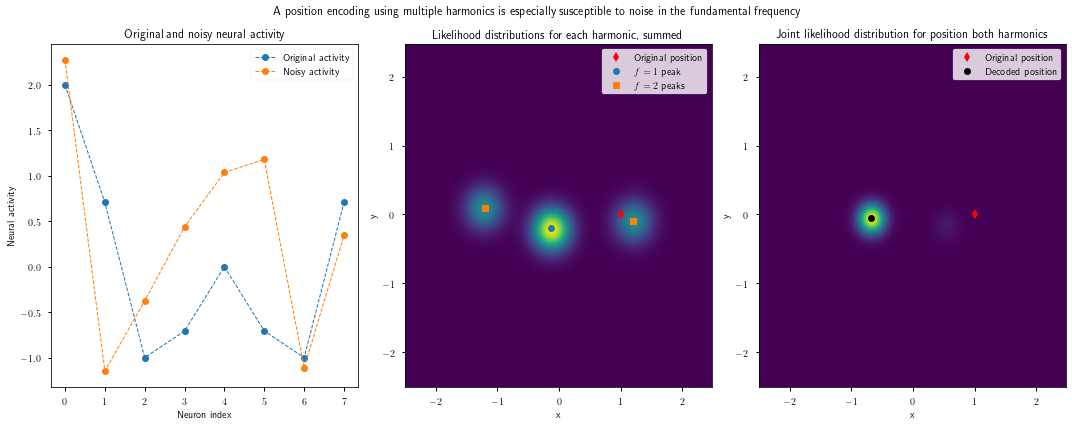

In [218]:
np.random.seed(17)

x,y = np.meshgrid(np.arange(-2.5,2.5,0.025), np.arange(0-2.5,2.5,0.025))

fig, axs = plt.subplots(1, 3, figsize=(15,6))

r0 = 1
theta0 = 0
sigma = 0.3
a0 = r0 * activity(theta0, [1,2], True)
a = a0 + np.random.randn(*a0.shape)
f1_L = gaussian2d(x, y, sigma, *xy_decoder(1)(a))
f2_L = np.mean(np.dstack([gaussian2d(x, y, sigma, *xy.ravel()) for xy in all_xy_decoder(2)(a)[:,:,0].T]), axis=2)
max_index = np.argmax(f1_L*f2_L)
decode_x, decode_y = x.ravel()[max_index], y.ravel()[max_index]

plt.sca(axs[0])
plt.plot(a0, 'o--', lw=1, label='Original activity')
plt.plot(a, 'o--', lw=1, label='Noisy activity')
plt.legend()
plt.xlabel('Neuron index')
plt.ylabel('Neural activity')
plt.title('Original and noisy neural activity')

plt.sca(axs[1])
plt.pcolormesh(x, y, f1_L, shading='gouraud')
# plt.pcolormesh(x, y, np.ma.masked_array(f2_L, f2_L < 0.1), shading='gouraud', cmap='magma', alpha=0.2)
# plt.pcolormesh(x, y, f2_L, shading='gouraud', cmap='inferno')
# plt.pcolormesh(x, y, f2_L, alpha=0.5, shading='gouraud')
# plt.pcolormesh(x, y, f1_L*f2_L, alpha=0.5, shading='gouraud')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Likelihood distribution for position from $f=1$')

plt.sca(axs[1])
plt.pcolormesh(x, y, f1_L + f2_L, shading='gouraud')
plt.plot(r0*np.cos(theta0), r0*np.sin(theta0), 'rd', label='Original position')
plt.plot(x.ravel()[np.argmax(f1_L)], y.ravel()[np.argmax(f1_L)], 'o', label='$f=1$ peak')
plt.plot([x.ravel()[np.argmax(f2_L*(x>0))], x.ravel()[np.argmax(f2_L*(x<0))]],
         [y.ravel()[np.argmax(f2_L*(x>0))], y.ravel()[np.argmax(f2_L*(x<0))]], 's', label='$f=2$ peaks')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Likelihood distributions for each harmonic, summed')

plt.sca(axs[2])
plt.pcolormesh(x, y, f1_L*f2_L, shading='gouraud')
plt.plot(r0*np.cos(theta0), r0*np.sin(theta0), 'rd', label='Original position')
plt.plot(decode_x, decode_y, 'ko', label='Decoded position')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Joint likelihood distribution for position both harmonics')

print(f'encoded xy = [{r0*np.cos(theta0)},{r0*np.sin(theta0)}]')
print(f'decoded xy = [{decode_x},{decode_y}]')

plt.suptitle(f'A position encoding using multiple harmonics is especially susceptible to noise in the fundamental frequency')
plt.tight_layout()
plt.savefig('plots/combined-harmonics-error-snapping-example.pdf')
plt.show()

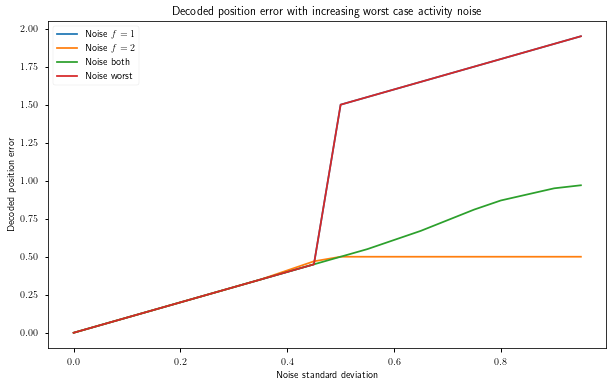

In [180]:
x,y = np.meshgrid(np.arange(-2.5,2.5,0.005), np.arange(-2.5,2.5,0.005))

sigma = 0.2
r0 = 1
theta0 = 0
output_positions_noise1 = []
output_positions_noise2 = []
output_positions_noise12 = []
output_positions_noise_worst = []
noise_range = np.arange(0, 1, 0.05)

for noise in noise_range:
	activity_noise = - noise*np.cos(2*np.pi*neuron_indices/N)
	# need to divide the activity by the number of harmonics so we're using the same signal energy to encode for both
	a = r0/2 * activity(theta0, [1,2], True) + activity_noise
	f1_L = gaussian2d(x, y, sigma, *xy_decoder(1)(a))
	f2_L = 1/2 * np.sum(np.dstack([gaussian2d(x, y, sigma, *xy.ravel()) for xy in all_xy_decoder(2)(a)[:,:,0].T]), axis=2)
	max_index = np.argmax(f1_L*f2_L)
	decode_x, decode_y = x.ravel()[max_index]*2, y.ravel()[max_index]*2
	output_positions_noise1.append(1 - decode_x)

	activity_noise = - noise*np.cos(2*2*np.pi*neuron_indices/N)
	a = r0/2 * activity(theta0, [1,2], True) + activity_noise
	f1_L = gaussian2d(x, y, sigma, *xy_decoder(1)(a))
	f2_L = 1/2 * np.sum(np.dstack([gaussian2d(x, y, sigma, *xy.ravel()) for xy in all_xy_decoder(2)(a)[:,:,0].T]), axis=2)
	max_index = np.argmax(f1_L*f2_L)
	decode_x, decode_y = x.ravel()[max_index]*2, y.ravel()[max_index]*2
	output_positions_noise2.append(1 - decode_x)

	activity_noise = -noise/2*np.cos(2*np.pi*neuron_indices/N) - noise/2*np.cos(2*2*np.pi*neuron_indices/N)
	a = r0/2 * activity(theta0, [1,2], True) + activity_noise
	f1_L = gaussian2d(x, y, sigma, *xy_decoder(1)(a))
	f2_L = 1/2 * np.sum(np.dstack([gaussian2d(x, y, sigma, *xy.ravel()) for xy in all_xy_decoder(2)(a)[:,:,0].T]), axis=2)
	max_index = np.argmax(f1_L*f2_L)
	decode_x, decode_y = x.ravel()[max_index]*2, y.ravel()[max_index]*2
	output_positions_noise12.append(1 - decode_x)

	activity_noise = - noise*np.cos(2*np.pi*neuron_indices/N) if noise <= 0.51 else -0.51*np.cos(2*np.pi*neuron_indices/N) + (noise-0.51)*np.cos(2*2*np.pi*neuron_indices/N)
	a = r0/2 * activity(theta0, [1,2], True) + activity_noise
	f1_L = gaussian2d(x, y, sigma, *xy_decoder(1)(a))
	f2_L = 1/2 * np.sum(np.dstack([gaussian2d(x, y, sigma, *xy.ravel()) for xy in all_xy_decoder(2)(a)[:,:,0].T]), axis=2)
	max_index = np.argmax(f1_L*f2_L)
	decode_x, decode_y = x.ravel()[max_index]*2, y.ravel()[max_index]*2
	output_positions_noise_worst.append(1 - decode_x)

plt.plot(noise_range, output_positions_noise1, label='Noise $f=1$')
plt.plot(noise_range, output_positions_noise2, label='Noise $f=2$')
plt.plot(noise_range, output_positions_noise12, label='Noise both')
plt.plot(noise_range, output_positions_noise_worst, label='Noise worst')
plt.legend()
plt.title('Decoded position error with increasing worst case activity noise')
plt.xlabel('Noise standard deviation')
plt.ylabel('Decoded position error')
plt.show()

In [ ]:
for noise in noise_range:
	for n in range(100)
	activity_noise = - noise*np.cos(2*np.pi*neuron_indices/N)
	a = a0 + np.random.randn(*a0.shape)
	f1_L = gaussian2d(x, y, sigma, *xy_decoder(1)(a))
	f2_L = np.mean(np.dstack([gaussian2d(x, y, sigma, *xy.ravel()) for xy in all_xy_decoder(2)(a)[:,:,0].T]), axis=2)
	max_index = np.argmax(f1_L*f2_L)
	decode_x, decode_y = x.ravel()[max_index], y.ravel()[max_index]


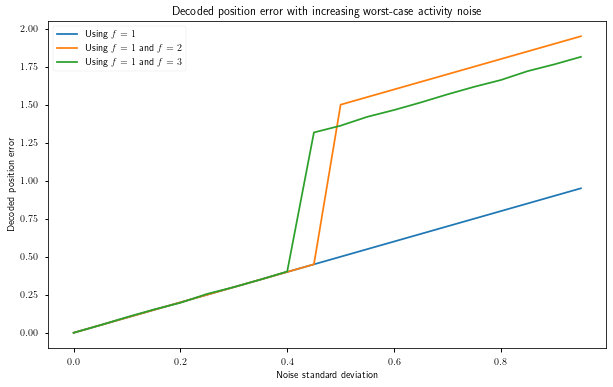

In [204]:
x,y = np.meshgrid(np.arange(-2.5,2.5,0.005), np.arange(-2.5,2.5,0.005))

sigma = 0.2
r0 = 1
theta0 = 0
output_positions1 = []
output_positions12 = []
output_positions13 = []
noise_range = np.arange(0, 1, 0.05)

for noise in noise_range:
	a = r0 * activity(theta0, [1], True) - noise*np.cos(2*np.pi*neuron_indices/N)
	f1_L = np.sum(np.dstack([gaussian2d(x, y, sigma, *xy.ravel()) for xy in all_xy_decoder(1)(a)[:,:,0].T]), axis=2)
	max_index = np.argmax(f1_L)
	decode_x, decode_y = x.ravel()[max_index], y.ravel()[max_index]
	output_positions1.append(np.sqrt((1 - decode_x)**2 + decode_y**2))

	# need to divide the activity by the number of harmonics so we're using the same signal energy to encode for both
	activity_noise = - noise*np.cos(2*np.pi*neuron_indices/N) if noise <= 0.51 else -0.51*np.cos(2*np.pi*neuron_indices/N) + (noise-0.51)*np.cos(2*2*np.pi*neuron_indices/N)
	a = r0/2 * activity(theta0, [1,2], True) + activity_noise
	f1_L = gaussian2d(x, y, sigma, *xy_decoder(1)(a))
	f2_L = 1/2 * np.mean(np.dstack([gaussian2d(x, y, sigma, *xy.ravel()) for xy in all_xy_decoder(2)(a)[:,:,0].T]), axis=2)
	max_index = np.argmax(f1_L*f2_L)
	decode_x, decode_y = x.ravel()[max_index]*2, y.ravel()[max_index]*2
	output_positions12.append(np.sqrt((1 - decode_x)**2 + decode_y**2))

	# need to divide the activity by the number of harmonics so we're using the same signal energy to encode for both
	activity_noise = noise*np.cos(2*np.pi*neuron_indices/N - 5*np.pi/6) if noise <= 1.42 else 1.42*np.cos(2*np.pi*neuron_indices/N - 5*np.pi/6) + (noise-1.42)*np.cos(2*3*np.pi*neuron_indices/N - np.pi/6)
	a = r0/2 * activity(theta0, [1,3], True) + activity_noise
	f1_L = gaussian2d(x, y, sigma, *xy_decoder(1)(a))
	f3_L = 1/2 * np.mean(np.dstack([gaussian2d(x, y, sigma, *xy.ravel()) for xy in all_xy_decoder(3)(a)[:,:,0].T]), axis=2)
	max_index = np.argmax(f1_L*f3_L)
	decode_x, decode_y = x.ravel()[max_index]*2, y.ravel()[max_index]*2
	output_positions13.append(np.sqrt((1 - decode_x)**2 + decode_y**2))

plt.plot(noise_range, output_positions1, label='Using $f=1$')
plt.plot(noise_range, output_positions12, label='Using $f=1$ and $f=2$')
plt.plot(noise_range, output_positions13, label='Using $f=1$ and $f=3$')
plt.legend()
plt.title('Decoded position error with increasing worst-case activity noise')
plt.xlabel('Noise standard deviation')
plt.ylabel('Decoded position error')
plt.savefig('plots/combined-harmonics-worst-case-error.pdf')
plt.show()

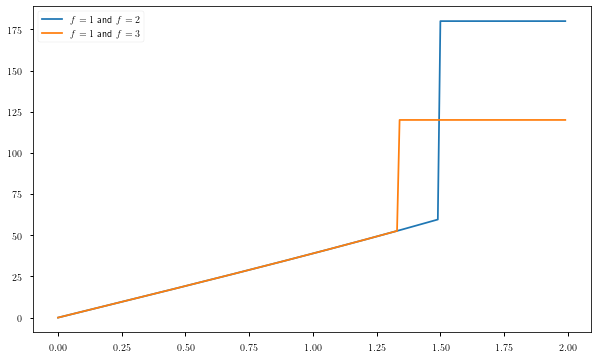

In [215]:
d_on_r = np.arange(0, 2, 0.01)

plt.plot(d_on_r, np.degrees(2*np.arcsin(1/3 * d_on_r)) * (d_on_r < 1.5) + 180 * (d_on_r >= 1.5), label='$f=1$ and $f=2$')
plt.plot(d_on_r, np.degrees(2*np.arcsin(1/3 * d_on_r)) * (d_on_r < 4/3) + 120 * (d_on_r >= 4/3), label='$f=1$ and $f=3$')
plt.legend()
plt.show()

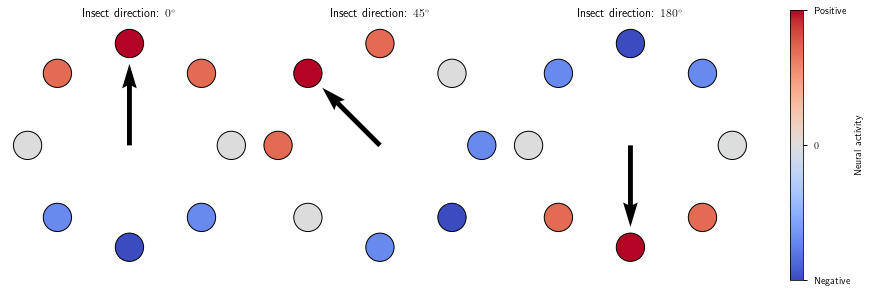

In [14]:
float_to_latex_frac = lambda x: '\\frac{'+'}{'.join((str(x) for x in (x).as_integer_ratio()))+'}' if (x).as_integer_ratio()[1] != 1 else str((x).as_integer_ratio()[0])
coefficient_to_string = lambda coeff, base: '0' if coeff == '0' else base if coeff == '1' else f'{coeff}{base}'

f = 1
angles = np.array([2,3,6])*2*np.pi/N
fig, axs = plt.subplots(1, 3, subplot_kw={"projection": "polar"}, figsize=(12,4), constrained_layout=True)
for i, (ax, phase) in enumerate(zip(axs.ravel(), angles)):
	neural_activity = activity(phase, [f], False)
	neural_activity_plot = ax.scatter(neuron_indices*2*np.pi/N, np.ones(N), c=neural_activity, s=800, edgecolors='black', linewidth=1, cmap='coolwarm', vmin=-1, vmax=1)

	phase_angle=decoder(f)(neural_activity)
	ax.quiver(0, 0, np.cos(phase_angle/f), np.sin(phase_angle/f), scale=3, color='black', width=0.02)

	ax.set_yticks([])
	ax.set_xticks([])
	ax.set_rlim(0,1.2)
	ax.spines['polar'].set_visible(False)
	pi = r'\pi' # can't put a backslash in a {} part of an f string
	ax.set_title(f'Insect direction: ${round(np.degrees(phase)-90)}^\\circ$')
	# ax.xaxis.set_major_formatter((lambda f: lambda x, pos: f'${coefficient_to_string(float_to_latex_frac((x/np.pi)*f % 2), pi)}$')(f))
	# ax.tick_params(pad=0)
	ax.grid(False)

cbar = fig.colorbar(neural_activity_plot, ax=axs.ravel().tolist(), label='Neural activity')
cbar.set_ticks([-1,0,1])
cbar.set_ticklabels(['Negative','$0$','Positive'])
# fig.suptitle('Rotational symmetry in the activity as the insect rotates about the origin', size=18)
# plt.tight_layout()
plt.savefig('plots/rotational-symmetry.svg')
plt.show()

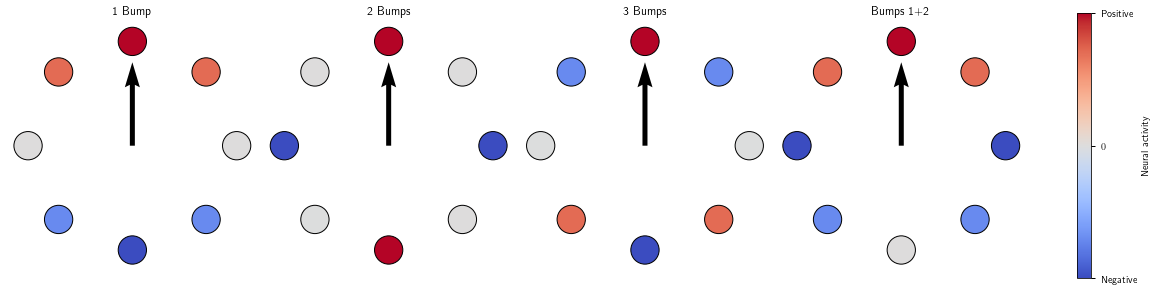

In [36]:
plot_theta=np.pi/2

fig, axs = plt.subplots(1, 4, subplot_kw={"projection": "polar"}, figsize=(16,4), constrained_layout=True)
for f, ax in zip([1,2,3,4], axs):
	neural_activity = activity(plot_theta, [f], True) if f != 4 else activity(plot_theta, [1,2], True)
	neural_activity_plot = ax.scatter(neuron_indices*2*np.pi/N, np.ones(N), c=neural_activity, s=800, edgecolors='black', linewidth=1, cmap='coolwarm', vmin=-1, vmax=1)

	# phase_angle=decoder(f)(neural_activity)
	# ax.quiver(0, 0, np.cos(phase_angle/f), np.sin(phase_angle/f), scale=3, color='black', width=0.02)
	ax.quiver(0, 0, np.cos(plot_theta), np.sin(plot_theta), scale=3, color='black', width=0.02)

	ax.set_title(f'{f if f != 4 else ""} Bump{"s" if f > 1 else ""} {"1+2" if f == 4 else ""}')
	ax.set_yticks([])
	ax.set_xticks([])
	ax.set_rlim(0,1.2)
	ax.spines['polar'].set_visible(False)
	pi = r'\pi' # can't put a backslash in a {} part of an f string
	# ax.xaxis.set_major_formatter((lambda f: lambda x, pos: f'${coefficient_to_string(float_to_latex_frac((x/np.pi)*f % 2), pi)}$')(f))
	# ax.tick_params(pad=0)
	ax.grid(False)

cbar = fig.colorbar(neural_activity_plot, ax=axs.ravel().tolist(), label='Neural activity')
cbar.set_ticks([-1,0,1])
cbar.set_ticklabels(['Negative','$0$','Positive'])
# plt.tight_layout()
plt.savefig('plots/ring-plot-harmonics.svg')
plt.show()

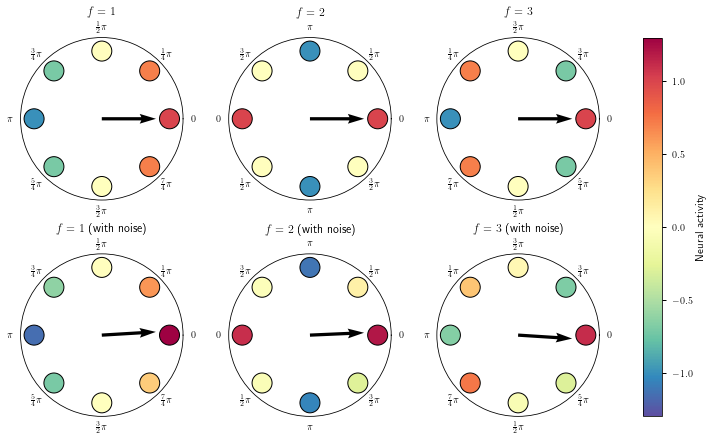

In [6]:
plot_theta=0
sigma=0.2


float_to_latex_frac = lambda x: '\\frac{'+'}{'.join((str(x) for x in (x).as_integer_ratio()))+'}' if (x).as_integer_ratio()[1] != 1 else str((x).as_integer_ratio()[0])
coefficient_to_string = lambda coeff, base: '0' if coeff == '0' else base if coeff == '1' else f'{coeff}{base}'

fig, axs = plt.subplots(2, 3, subplot_kw={"projection": "polar"}, figsize=(10,6), constrained_layout=True)
for i, ax_row in enumerate(axs):
	noisy = i != 0
	for n, ax in enumerate(ax_row):
		f = n+1
		neural_activity = activity(plot_theta, [f], False) + (sigma*np.random.randn(N,1) if noisy else 0)
		neural_activity_plot = ax.scatter(neuron_indices*2*np.pi/N, np.ones(N), c=neural_activity, s=400, edgecolors='black', linewidth=1, cmap='Spectral_r', vmin=-1-1.5*sigma, vmax=1+1.5*sigma)

		phase_angle=decoder(f)(neural_activity)
		ax.quiver(0, 0, np.cos(phase_angle/f), np.sin(phase_angle/f), scale=3, color='black', width=0.02)

		ax.set_title(f'$f = {f}${" (with noise)" if noisy else ""}')
		ax.set_yticks([])
		ax.set_rlim(0,1.2)
		pi = r'\pi' # can't put a backslash in a {} part of an f string
		ax.xaxis.set_major_formatter((lambda f: lambda x, pos: f'${coefficient_to_string(float_to_latex_frac((x/np.pi)*f % 2), pi)}$')(f))
		ax.tick_params(pad=0)
		ax.grid(False)

fig.colorbar(neural_activity_plot, ax=axs.ravel().tolist(), label='Neural activity')
# plt.tight_layout()
plt.savefig('plots/ring-plot-harmonics-with-noise.pdf')
plt.show()

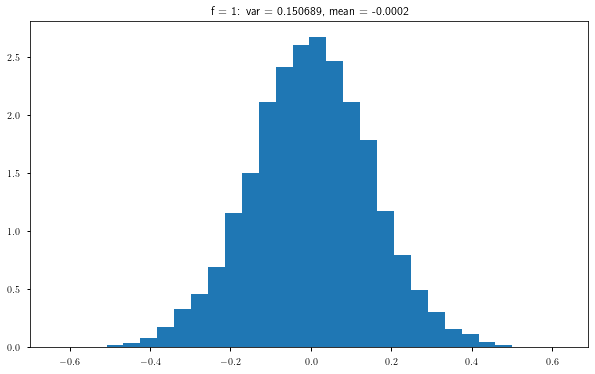

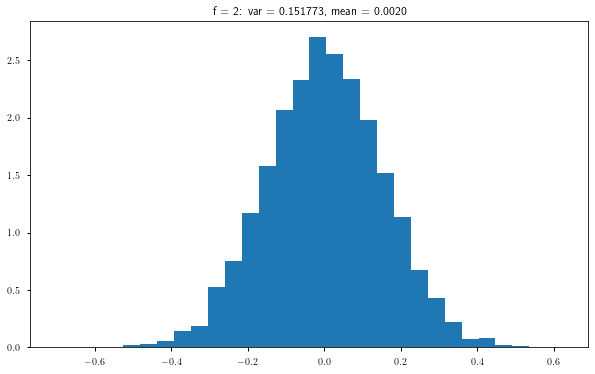

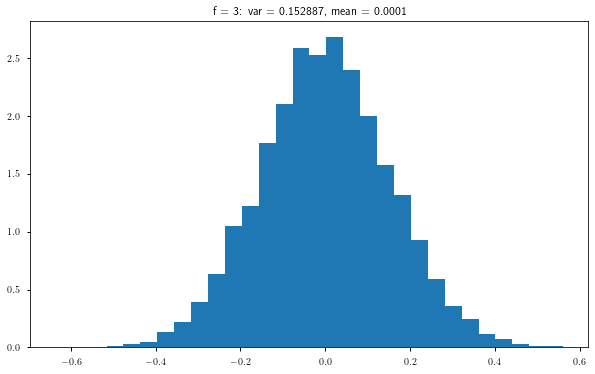

In [8]:
sigma = 0.3

for f in range(1,4):
	errors = decoder(f)(encoder(f)(np.zeros(10000)) + sigma*np.random.randn(N,10000))
	plt.hist(errors, 30, density=True)
	plt.title(f'f = {f}: var = {np.sqrt(errors.var()):4f}, mean = {errors.mean():.4f}')
	plt.show()

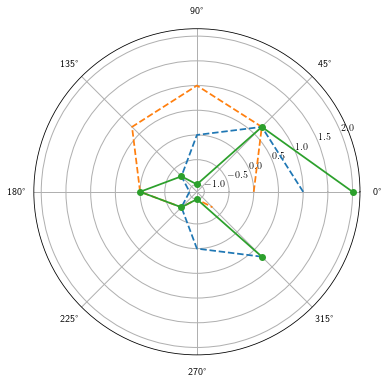

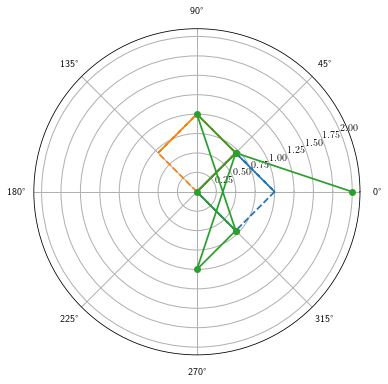

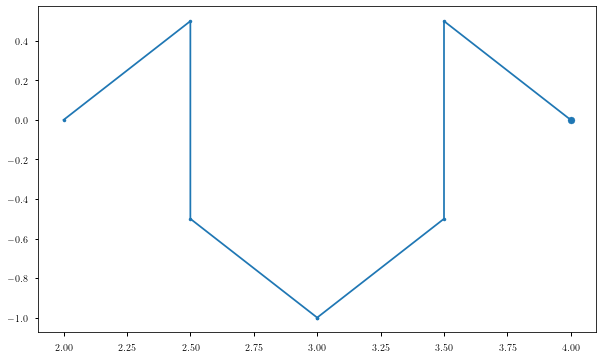

In [11]:
a = activity(0,[1,2],True)
f=1

ax = a*np.cos(2*f*np.pi/N*neuron_indices)
ay = a*np.sin(2*f*np.pi/N*neuron_indices)

plt.figure(figsize=(6,6))
plt.polar(2*np.pi/N*neuron_indices, np.cos(2*f*np.pi/N*neuron_indices), '--')
plt.polar(2*np.pi/N*neuron_indices, np.sin(2*f*np.pi/N*neuron_indices), '--')
plt.polar(2*np.pi/N*neuron_indices, a, 'o-')
plt.show()
plt.polar(2*np.pi/N*neuron_indices + (np.cos(2*f*np.pi/N*neuron_indices)<0)*np.pi, abs(np.cos(2*f*np.pi/N*neuron_indices)), '--')
plt.polar(2*np.pi/N*neuron_indices + (np.sin(2*f*np.pi/N*neuron_indices)<0)*np.pi, abs(np.sin(2*f*np.pi/N*neuron_indices)), '--')
plt.polar(2*np.pi/N*neuron_indices + (a<0)*np.pi, abs(a), 'o-')
plt.show()
# plt.plot(ax,ay, '.')
# plt.show()
plt.plot(np.cumsum(ax), np.cumsum(ay), '.-')
plt.scatter(np.cumsum(ax)[-1], np.cumsum(ay)[-1])

Here we can just see what the superposition of harmonics (with unit amplitude) looks like, both abstractly and with a small number of neurons

In [12]:
def decode_single_harmonic_angle(a, f):
	x = np.sum(a * np.cos(2*f*np.pi/N*neuron_indices))
	y = np.sum(a * np.sin(2*f*np.pi/N*neuron_indices))
	return np.arctan2(y, x)/f

decode_activity = lambda a, fs: np.mean([decode_single_harmonic_angle(a,f) for f in fs])
corrupt_with_noise = lambda a, noise_stddev: a + noise_stddev*np.random.randn(*a.shape)
decode_activity_error = lambda theta, fs, noise_stddev: theta + decode_activity(corrupt_with_noise(activity(theta, fs, True), noise_stddev), fs)

decode_activity_error(0, [1], 0.1)

-0.04089325569736168

If we encode the same angle into multiple harmonics at the same time, then we can try and decode a noise-corrupted signal and recover the original angle

* each harmonic can only output an angle in $[0,\frac{2\pi}{f}]$ or equivalently $[-\frac{\pi}{f},\frac{\pi}{f}]$

The questions are:
* Are higher or lower harmonics more or less robust to noise?
* Does encoding with 2 harmonics at once then averaging the decoded angles improve noise robustness?

## Decoding with higher harmonics

Here we see the wrapping behaviour with higher harmonics

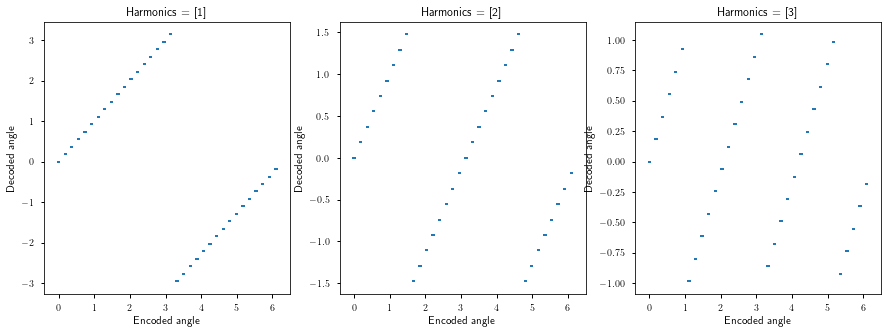

In [13]:
theta_range = np.arange(0,2*np.pi,np.pi/17)

def violin_plot(fs):
	plt.violinplot([[decode_activity(activity(theta, fs, True) + 0.1*np.random.randn(N), fs) for _ in range(1000)] for theta in theta_range], positions=theta_range, widths=theta_range[1]-theta_range[0])
	plt.xlabel('Encoded angle')
	plt.ylabel('Decoded angle')
	plt.title(f'Harmonics = {fs}')

fig, axs = plt.subplots(1, 3, figsize=(15,5))
plt.sca(axs[0])
violin_plot([1])
plt.sca(axs[1])
violin_plot([2])
plt.sca(axs[2])
violin_plot([3])

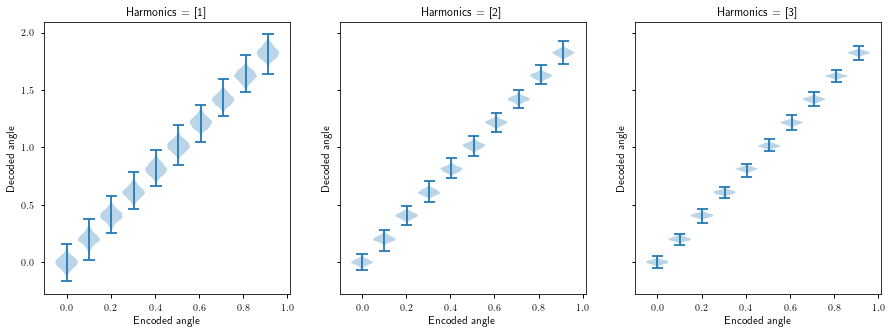

In [14]:
theta_range = np.arange(0,np.pi/3.2,np.pi/31)

def violin_plot_error(fs):
	plt.violinplot([[decode_activity_error(theta, fs, 0.1) for _ in range(1000)] for theta in theta_range], positions=theta_range, widths=theta_range[1]-theta_range[0])
	plt.xlabel('Encoded angle')
	plt.ylabel('Decoded angle')
	plt.title(f'Harmonics = {fs}')

fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)
plt.sca(axs[0])
violin_plot_error([1])
plt.sca(axs[1])
violin_plot_error([2])
plt.sca(axs[2])
violin_plot_error([3])

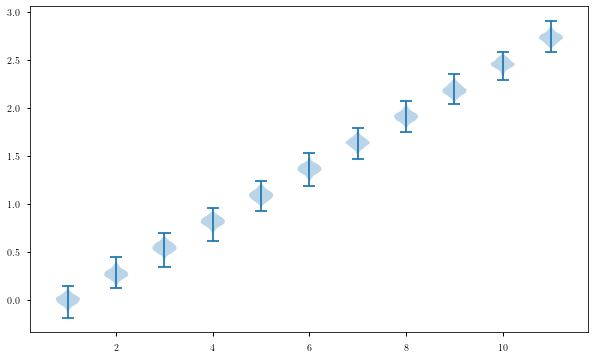

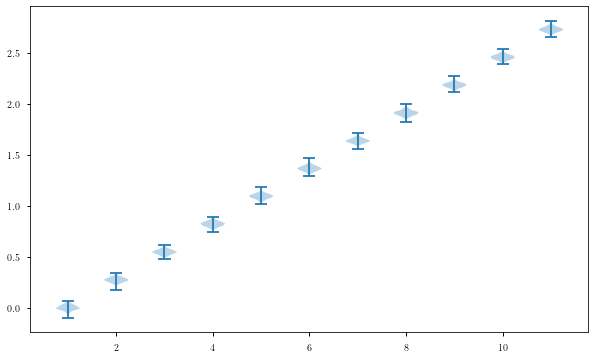

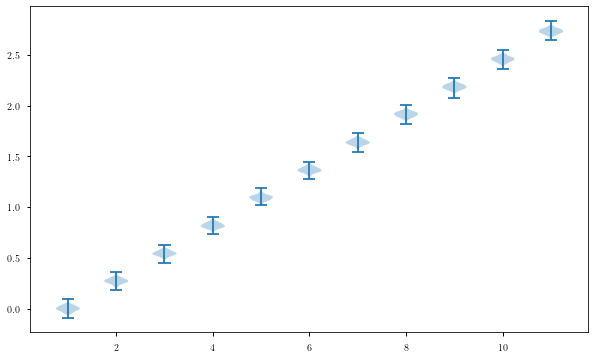

In [15]:
fs = [1]
theta_range = np.arange(0,np.pi/2.2,np.pi/23)
plt.violinplot([[decode_activity_error(theta, fs, 0.1) for _ in range(1000)] for theta in theta_range])
plt.show()

fs = [2]
plt.violinplot([[decode_activity_error(theta, fs, 0.1) for _ in range(1000)] for theta in theta_range])
plt.show()

fs = [1,2]
plt.violinplot([[decode_activity_error(theta, fs, 0.1) for _ in range(1000)] for theta in theta_range])
plt.show()

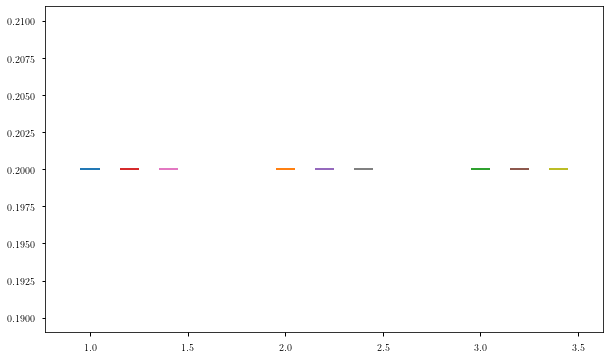

In [16]:
theta = 0.2
fs = [1]
plt.violinplot(np.array([decode_activity(activity(theta, fs, True) + 0.02*np.random.randn(N), fs) for _ in range(1000)]), [1], widths=0.2)
plt.violinplot(np.array([decode_activity(activity(theta, fs, True) + 0.05*np.random.randn(N), fs) for _ in range(1000)]), [2], widths=0.2)
plt.violinplot(np.array([decode_activity(activity(theta, fs, True) + 0.1*np.random.randn(N), fs) for _ in range(1000)]), [3], widths=0.2)

fs = [2]
plt.violinplot(np.array([decode_activity(activity(theta, fs, True) + 0.02*np.random.randn(N), fs) for _ in range(1000)]), [1.2], widths=0.2)
plt.violinplot(np.array([decode_activity(activity(theta, fs, True) + 0.05*np.random.randn(N), fs) for _ in range(1000)]), [2.2], widths=0.2)
plt.violinplot(np.array([decode_activity(activity(theta, fs, True) + 0.1*np.random.randn(N), fs) for _ in range(1000)]), [3.2], widths=0.2)

fs = [1,2]
plt.violinplot(np.array([decode_activity(activity(theta, fs, True) + 0.02*np.random.randn(N), fs) for _ in range(1000)]), [1.4], widths=0.2)
plt.violinplot(np.array([decode_activity(activity(theta, fs, True) + 0.05*np.random.randn(N), fs) for _ in range(1000)]), [2.4], widths=0.2)
plt.violinplot(np.array([decode_activity(activity(theta, fs, True) + 0.1*np.random.randn(N), fs) for _ in range(1000)]), [3.4], widths=0.2)
plt.show()

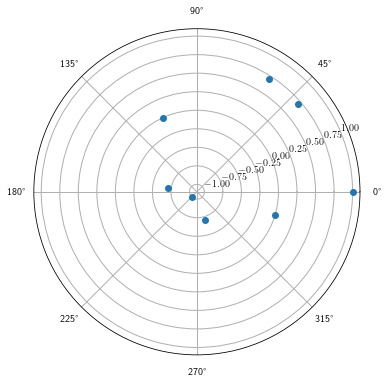

In [17]:
plt.polar(activity(0, [1], True), 'o')

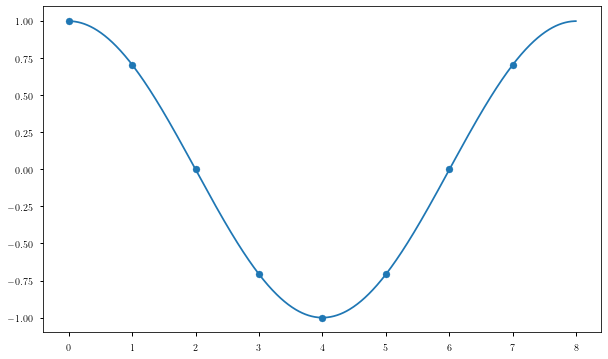

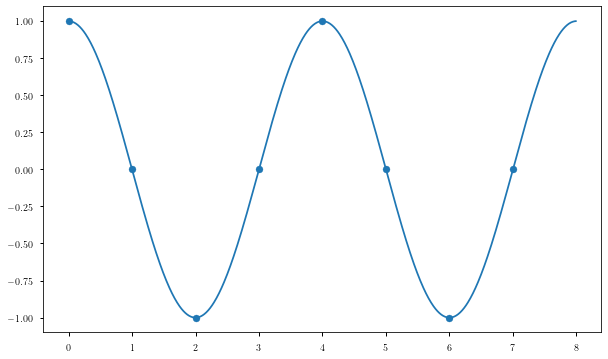

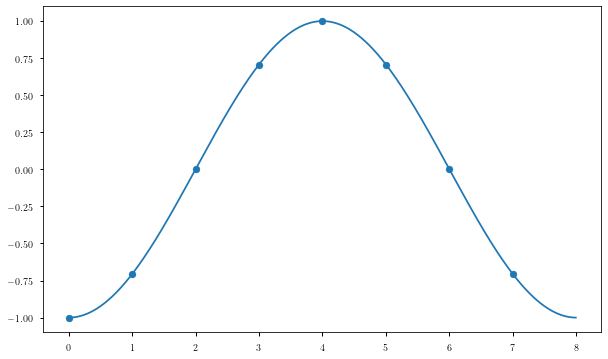

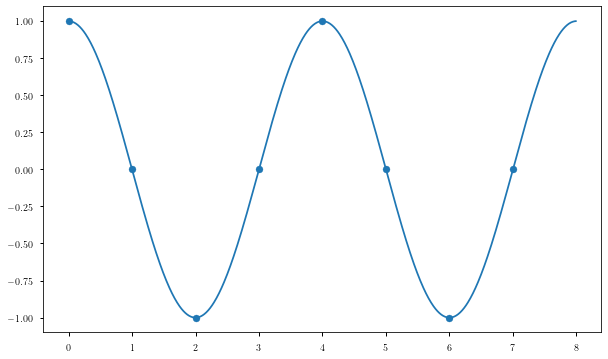

In [18]:
theta = np.pi
neuron_indices_high_res = np.arange(0,N,0.01)
activity = lambda theta, f: np.cos(theta*f + 2*np.pi*f*neuron_indices/N)
activity_high_res = lambda theta, f: np.cos(theta*f + 2*np.pi*f*neuron_indices_high_res/N)
# plot_activity = lambda theta, f: plt.plot(neuron_indices_high_res, activity(theta, f))
def plot_activity(theta, f):
	plt.plot(neuron_indices_high_res, activity_high_res(theta, f))
	plt.scatter(neuron_indices, activity(theta, f))
plot_activity_combined = lambda theta, f1, f2: plt.plot(neuron_indices_high_res, activity_high_res(theta, f1) +  activity_high_res(theta, f2))

plot_activity(0, 1)
plt.show()
plot_activity(0, 2)
plt.show()

plot_activity(np.pi, 1)
plt.show()
plot_activity(np.pi, 2)
plt.show()

In [19]:
activity(0,1)

array([[ 1.00000000e+00],
       [ 7.07106781e-01],
       [ 6.12323400e-17],
       [-7.07106781e-01],
       [-1.00000000e+00],
       [-7.07106781e-01],
       [-1.83697020e-16],
       [ 7.07106781e-01]])

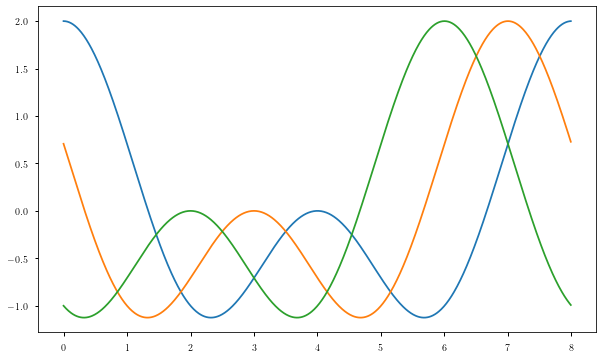

In [20]:
plot_activity_combined(0, 1, 2)
plot_activity_combined(np.pi/4, 1, 2)
plot_activity_combined(np.pi/2, 1, 2)
plt.show()

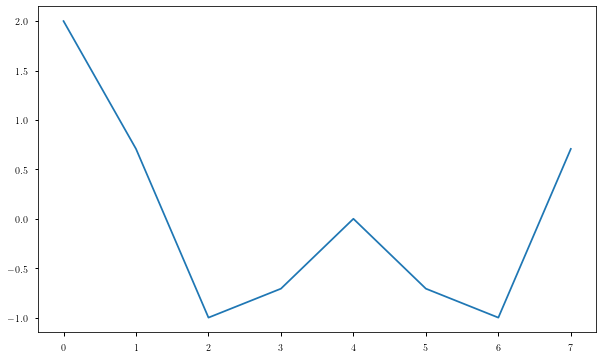

In [21]:
a = activity(0, 1) + activity(0,2)
plt.plot(a)

ValueError: x and y must have same first dimension, but have shapes (800,) and (8, 800)

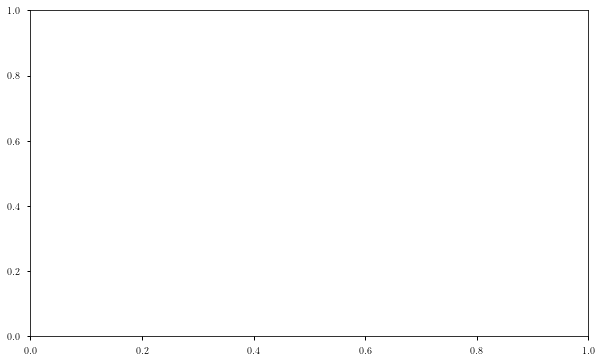

In [22]:
plt.plot(neuron_indices_high_res, activity(np.pi/2, 1) * np.cos(2*np.pi/N*neuron_indices_high_res), label='cos')
plt.plot(neuron_indices_high_res, activity(np.pi/2, 1) * np.sin(2*np.pi/N*neuron_indices_high_res), label='sin')
angle = np.arctan2(np.sum(activity(np.pi/2, 1) * np.sin(2*np.pi/N*neuron_indices_high_res)), np.sum(activity(np.pi/2, 1) * np.cos(2*np.pi/N*neuron_indices_high_res))) % (2*np.pi)
plt.axvline(angle*N/2/np.pi)
plt.title(f'{angle}')
plt.legend()
plt.show()

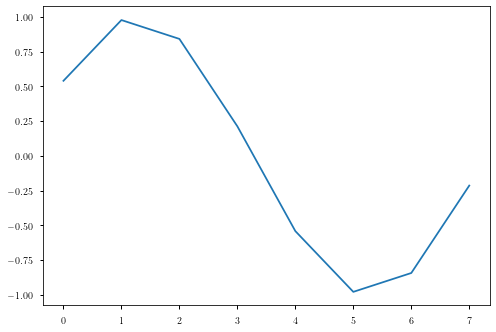

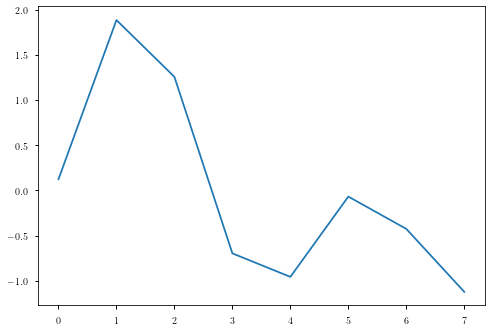

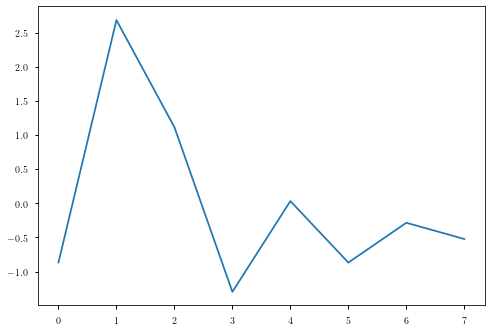

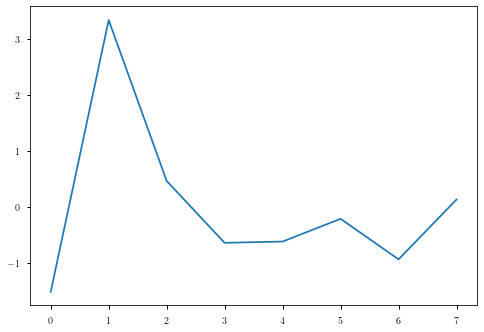

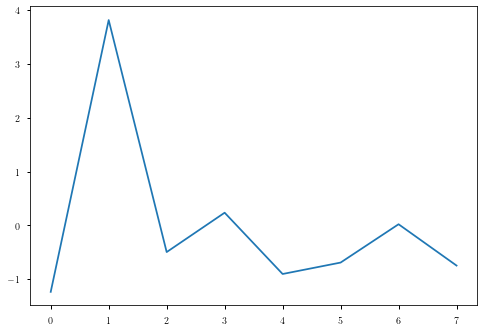

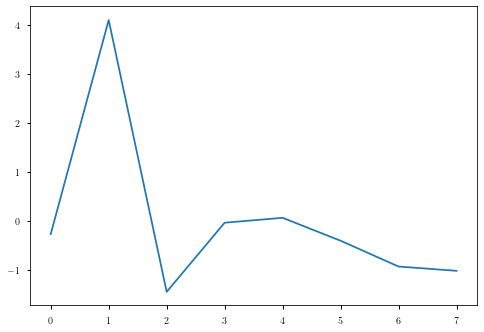

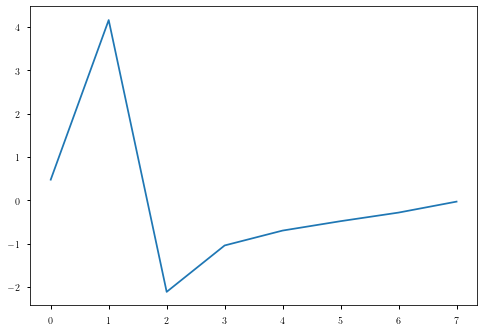

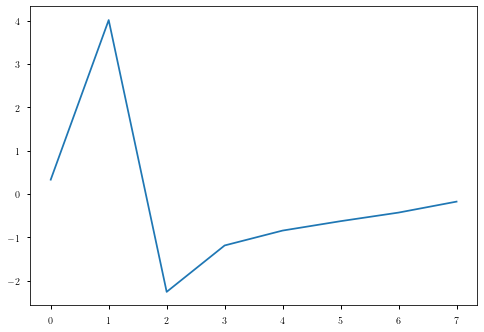

In [ ]:
for max_f in range(1,8+1):
	plt.plot(np.sum(np.array([activity(-1,f) for f in range(1,max_f+1)]), axis=0))
	plt.show()

angle1 = -0.1773259789768577
angle2 = 0.3894344092096803


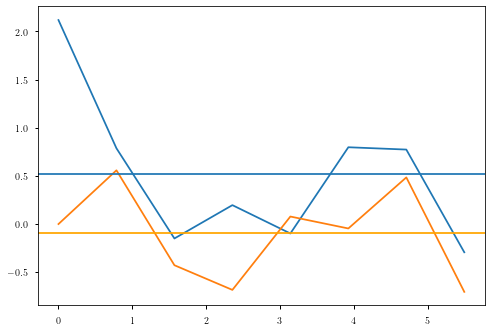

In [ ]:
proj_cos = lambda activity, f: activity * np.cos(2*np.pi*f/N*neuron_indices_angle)
proj_sin = lambda activity, f: activity * np.sin(2*np.pi*f/N*neuron_indices_angle)
neuron_indices_high_res_angle = 2*np.pi/N*neuron_indices_high_res
neuron_indices_angle = 2*np.pi/N*neuron_indices

a = activity(0, 1) + activity(0, 2) + 0.2*np.random.randn(*neuron_indices_angle.shape)
f = 1
plt.plot(neuron_indices_angle, proj_cos(a, f))
plt.plot(neuron_indices_angle, proj_sin(a, f))
plt.axhline(np.mean(proj_cos(a, f)))
plt.axhline(np.mean(proj_sin(a, f)), color='orange')

print(f'angle1 = {np.arctan2(proj_sin(a, 1).sum(), proj_cos(a, 1).sum())}')
print(f'angle2 = {np.arctan2(proj_sin(a, 2).sum(), proj_cos(a, 2).sum())}')

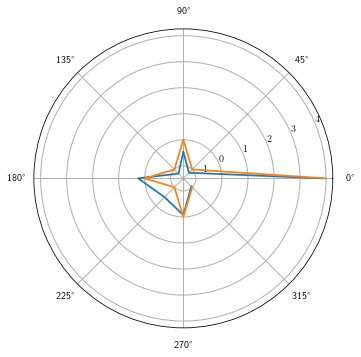

In [ ]:
plt.polar(neuron_indices_angle, activity(0, 1) + activity(0, 2) + activity(0,3) + activity(0,4) + 0.2*np.random.randn(*neuron_indices.shape))
plt.polar(neuron_indices_angle, activity(0, 1) + activity(0, 2) + activity(0,3) + activity(0,4))

ValueError: x and y must have same first dimension, but have shapes (800,) and (8,)

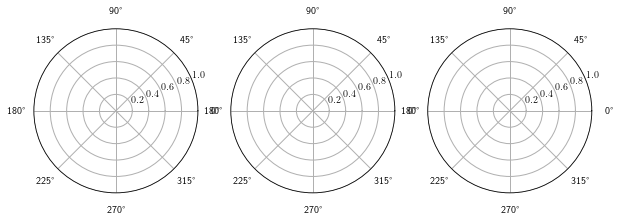

In [ ]:
proj_cos = lambda activity: activity * np.cos(2*np.pi/N*neuron_indices_high_res)
proj_sin = lambda activity: activity * np.sin(2*np.pi/N*neuron_indices_high_res)
neuron_indices_high_res_angle = 2*np.pi/N*neuron_indices_high_res

fig, axs = plt.subplots(1,3, figsize=(10,5), subplot_kw={'projection':'polar'})
axs[0].plot(neuron_indices_high_res_angle, activity(0, 1))
axs[1].plot(neuron_indices_high_res_angle, proj_cos(activity(0, 1)))
axs[2].plot(neuron_indices_high_res_angle, proj_sin(activity(0, 1)))
plt.show()
plt.polar(2*np.pi/N*neuron_indices_high_res, activity(0, 2))
plt.show()
plt.polar(2*np.pi/N*neuron_indices_high_res, activity(0, 1) + activity(0,2))
plt.show()

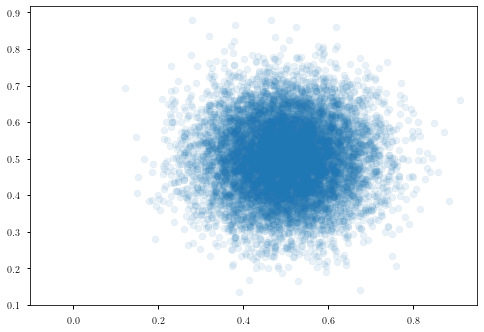

In [ ]:
x = .5
y = .5

num_points = 10000
sigma = 0.1
points = np.array([x + sigma*np.random.randn(num_points), y + sigma*np.random.randn(num_points)])
r = np.sqrt(np.sum(points**2, axis=0))
r0 = np.sqrt(x**2 + y**2)
angle = np.arctan2(points[1], points[0])
angle0 = np.arctan2(y, x)

plt.scatter(points[0,:], points[1,:], alpha=0.1)
plt.xlim([min(-0.1,plt.xlim()[0]),plt.xlim()[1]])
plt.show()

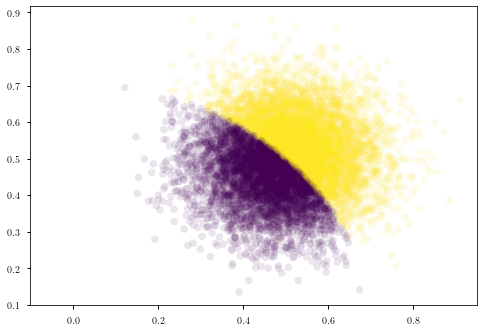

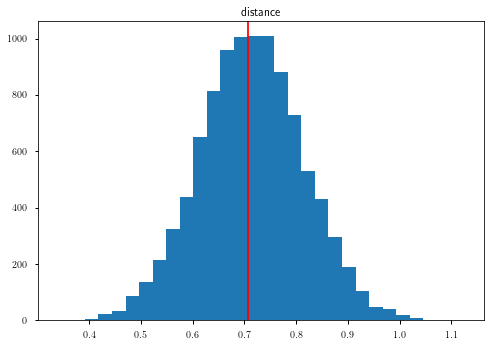

In [ ]:
plt.scatter(points[0], points[1], c=r>=r0, alpha=0.1)
plt.xlim([min(-0.1,plt.xlim()[0]),plt.xlim()[1]])
plt.show()
plt.hist(r, 30)
plt.title('distance')
plt.axvline(r0, color='red')
plt.show()

In [ ]:
def circ_dist(x):
	return np.arctan(np.sin(x) / np.cos(x))

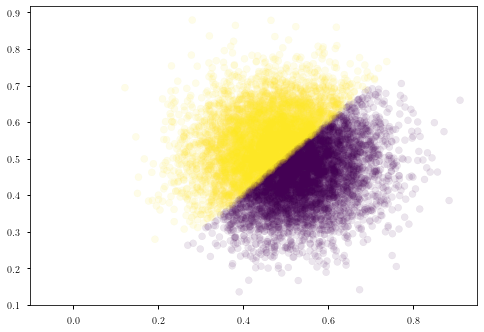

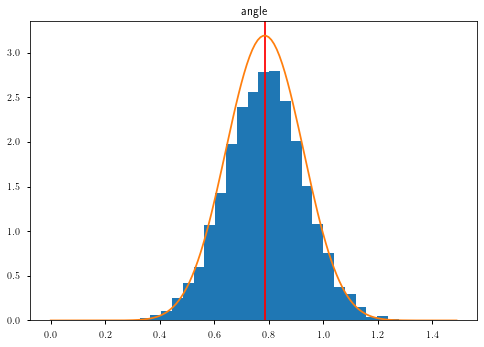

In [ ]:
plt.scatter(points[0], points[1], c=angle>=angle0, alpha=0.1)
plt.xlim([min(-0.1,plt.xlim()[0]),plt.xlim()[1]])
plt.show()

theta_dash = np.arange(0, 1.5,0.01)

plt.hist(angle, 30, density=True)
plt.axvline(angle0, color='red')
# plt.plot(theta_dash, 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-(theta_dash - angle0)**2 / (2*sigma*2)))
plt.plot(theta_dash, 1/(np.sqrt(2*np.pi)*sigma*1.25) * np.exp(-np.tan(theta_dash - angle0)**2/ (.2*sigma*2)))
plt.title('angle')
plt.show()

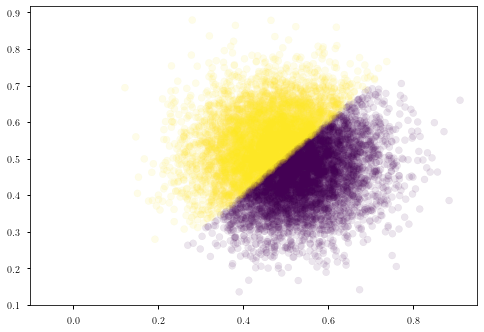

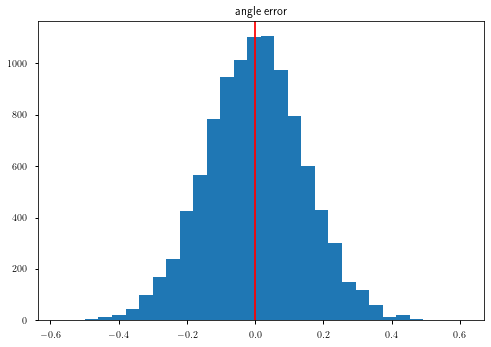

In [ ]:
plt.scatter(points[0], points[1], c=circ_dist(angle-angle0)>=0, alpha=0.1)
plt.xlim([min(-0.1,plt.xlim()[0]),plt.xlim()[1]])
plt.show()
plt.hist(circ_dist(angle-angle0), 30)
plt.axvline(0, color='red')
plt.title('angle error')
plt.show()